In [1]:
# Reference: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2023-07-22 14:23:52.323914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# For saving result to tempoary file
import sys
import logging

nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-07-22 14:24:11.322478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# Get BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-512_A-8' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [5]:
# Build the model
def build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, dropout = 0.1):
#     preprocessor = hub.load(tfhub_handle_preprocess)
#     text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
#     tokenize = hub.KerasLayer(preprocessor.tokenize)
#     tokenized_inputs = [tokenize(segment) for segment in text_inputs]
    
#     seq_length = 512  # Your choice here.
#     bert_pack_inputs = hub.KerasLayer(
#         preprocessor.bert_pack_inputs,
#         arguments=dict(seq_length=seq_length))  # Optional argument.
#     encoder_inputs = bert_pack_inputs(tokenized_inputs)
    
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(dropout)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [6]:
# Compile the model
def compile_model(classifier_model, train_ds, lr = 3e-6, epochs = 5):
    # model fine tuning
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')

    classifier_model.compile(optimizer=optimizer,
                             loss=loss,
                             metrics=metrics)
    return classifier_model

In [7]:
# Prepare dataset
def prepare_data(dataset):
    # Load the dataset
    df = pd.read_csv(f'../dataset/{dataset}', encoding='utf-8').dropna()
    df.columns = ['label', 'text']
    
    # # Sample only 20% to test BERT training faster
    # df, df_discard = train_test_split(df, test_size=0.99, random_state=7)

    # Use sklearn to split the dataset into training, validating and testing
    train_df, val_df = train_test_split(df, test_size=0.3, random_state=7)
    val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=7)

    # Create training dataset
    AUTOTUNE = tf.data.AUTOTUNE
    batch_size = 8

    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_df['text'].values, train_df['label'].values)
    )
    train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

    # Create validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices(
        (val_df['text'].values, val_df['label'].values)
    )
    val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

    # Create testing dataset
    test_ds = tf.data.Dataset.from_tensor_slices(
        (test_df['text'].values, test_df['label'].values)
    )
    test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds


In [8]:
# Show result
def evaluate_model(classifier_model, test_ds):
    # Evaluate performance
    loss, accuracy = classifier_model.evaluate(test_ds)

    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')
    
def show_history(history, shouldSave = False, modelName = ''):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    fig.savefig('saved_model/' + modelName + '.png')

In [ ]:
# Best learning rate by experiment is 3e-5

models = [
    # 'small_bert/bert_en_uncased_L-2_H-128_A-2',
    # 'small_bert/bert_en_uncased_L-4_H-256_A-4',
    # 'small_bert/bert_en_uncased_L-4_H-512_A-8',
    'small_bert/bert_en_uncased_L-8_H-512_A-8',
    # 'small_bert/bert_en_uncased_L-10_H-128_A-2',
    # 'small_bert/bert_en_uncased_L-12_H-256_A-4',
    # 'small_bert/bert_en_uncased_L-12_H-512_A-8'
]


for modelName in models:
    print("Training for model: ", modelName)
    tfhub_handle_encoder = map_name_to_handle[modelName]
    tfhub_handle_preprocess = map_model_to_preprocess[modelName]
    model = build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, 0.1)
    train_ds, val_ds, test_ds = prepare_data("best_dataset.csv")
    classifier_model = compile_model(model, train_ds, 3e-5)
    history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=7)
    
    print("Performance for model: ", modelName)
    evaluate_model(classifier_model, test_ds)
    show_history(history, True, modelName)
    
    classifier_model.save('saved_model/' + modelName)

Training for model:  small_bert/bert_en_uncased_L-8_H-512_A-8
Epoch 1/7
1272/2886 [============>.................] - ETA: 1:46 - loss: 0.3282 - binary_accuracy: 0.8696

In [80]:
# Save the model
classifier_model.save('saved_model/smokeTestBertSmsClassifier', include_optimizer=False)

In [75]:
classifier_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [76]:
#Try loading
from keras.models import load_model

loaded_model = load_model('saved_model/smokeTestBertSmsClassifier', compile=False)

In [15]:
# Plot confusion matrix and graph
def plot_confusion_matrix(y, y_pred, type, target_names = ['Ham', 'Spam']):
    print('Confusion matrix - ' + type)
    print(classification_report(y, y_pred, target_names=target_names))

    # Plot the confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - ' + type)
    plt.show()

In [16]:
# Evaluate performance in term of confusing matrix
# Check confusion matrix given dataset and model. Reference: https://colab.research.google.com/drive/1kEg0SnYNtw_IJwu_kl5y3qRVs-BKBmNO#scrollTo=_r4smPUZymS5
def evaluateDatasetConfusionMatrix(dataset, model):
    train_ds, val_ds, test_ds = prepare_data(dataset)

    y_val_pred = tf.math.round(tf.nn.sigmoid(model.predict(val_ds)))
    y_test_pred = tf.math.round(tf.nn.sigmoid(model.predict(test_ds)))

    y_val = tf.Variable([], dtype=tf.int64)
    for features, label in val_ds.take(-1):
        y_val = tf.concat([y_val, label], 0)

    y_test = tf.Variable([], dtype=tf.int64)
    for features, label in test_ds.take(-1):
        y_test = tf.concat([y_test, label], 0)
    

    plot_confusion_matrix(y_val, y_val_pred, 'Validation')
    plot_confusion_matrix(y_test, y_test_pred, 'Testing')

409/409 [==============================] - 12s 29ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham       0.94      0.97      0.95      3100
        Spam       0.98      0.94      0.96      3528

    accuracy                           0.96      6628
   macro avg       0.96      0.96      0.96      6628
weighted avg       0.96      0.96      0.96      6628



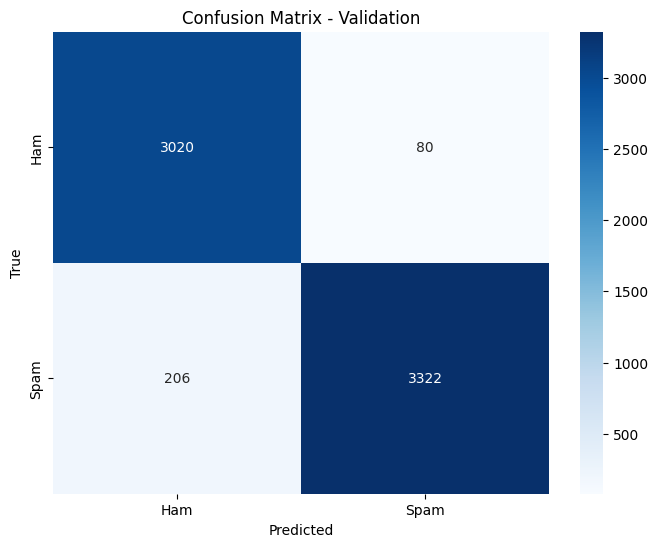

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham       0.94      0.97      0.95      1510
        Spam       0.98      0.94      0.96      1755

    accuracy                           0.96      3265
   macro avg       0.96      0.96      0.96      3265
weighted avg       0.96      0.96      0.96      3265



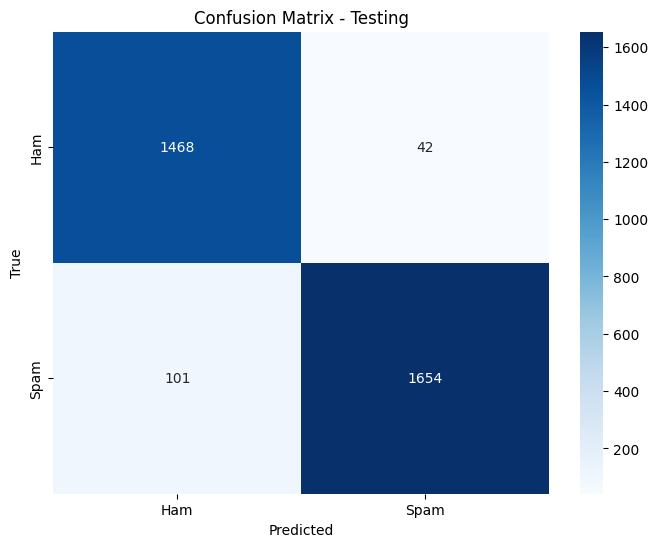

In [17]:
evaluateDatasetConfusionMatrix('best_dataset.csv', classifier_model)

In [77]:
test_data_spam = [
    "咪咕 帶 您 體驗 正版 的 音樂 世界 新 歌 搶鮮 試聽 潮流 鈴音 隨心換 百場 歌友會 演唱會 門票 免費 搶 number 月 日前 登錄 還 能 免費 領取 number m 流量 下載 點擊 link",
    "中移 通訊 手機 免費送 平板 免費 拿 只 需 number 元 價值 number 元 的 g 智慧型手機 number 元 的 平板 電腦 number 元 話費 生活 廣場 斜對面 金源 豐 手機 大 賣場",
    "和 娛樂 雙周刊 港 囧 來 襲 攜 薇 包 高空 冒險 情 在 囧 途 爆笑 歸來 詳情 點擊 link ctpn 手慢 無送 又 逢 開學 季 噹噹 買書 享 優惠 啦 每周 一至 周五 下午 三點 當 當 圖書 音像 禮券 等 你 來 搶 點擊 link 如 不 需 接收 本刊 回復 hylzt 退訂",
    "yes 月 日 添益 寶 用戶 狂歡 日 就是 它 了 當天 您 在 指定 商戶 門店 消費 可享 折 優惠 最高 省 元 哦 添 用戶 專享 超高 收益 理財產品 等 著 您 這麼 賺 當然 得 加入 添益 寶 登錄 翼 支付 客戶端 詳情 一網打盡 翼 支付",
    "尊敬 的 客戶 根據 您 的 流量 使用 狀況 推薦 您 回復 sjll number 開通 number 元 流量 套餐 現在 辦理 年內 每月 再 送 您 number m 省內 流量 加量 不 加價 流量 大 優惠 詳詢 number 中國移動",
]

test_data_ham = [
    "店鋪 導航 設置 失敗 店鋪 導航 已經 修改 了 天 了 在 微信 界面 還是 沒有 修改",
    "重要 買家 無法 支付 和 地區 不 支持 最近 一直 會 出現 有 買家 選擇 收貨 地址 顯示 不 支持 的 情況 發生 但是 其 所在區域 是 支持 的 比如 河北 有 兩位 用戶 均 不 支持 該 地區 配送 但 運費 模板 上 是 支持 的 另外 還有 相同 地區 的 用戶 有人 可 下單 有人 不可 下單 甚至 連 支付 方式 都 看不到 而 如上 情況 都 是 在 關注 和 註冊 以後 發生 的",
    "認證 企業 信息 被盜 用 怎麼辦 企業 信息 無法 認證 信息 已 被 認證 盜用 請 有贊 平臺 給予 人工 認證 並把 盜用 信息 帳號 給予 刪除",
    "註冊 後 原來 微信 開發 的 菜單 都 失效 了 怎麼辦 你好 註冊 了 有贊 後 原來 自己 找人 開發 的 菜單 都 失效 了 請問 怎麼辦",
    "顧客 接待 客戶端 用不了 客戶 接待 客戶端 更新 之後 沒什麼 上不了 只能 上 網頁版 的"
]

print("SPAM")
for data in test_data_spam:
    result = loaded_model.predict([data])
    print(result)
    
print("\nHAM")
for data in test_data_ham:
    result = loaded_model.predict([data])
    print(result)

SPAM
1/1 [==============================] - 1s 557ms/step
[[6.0945992]]
1/1 [==============================] - 0s 52ms/step
[[5.902234]]
1/1 [==============================] - 0s 50ms/step
[[5.507902]]
1/1 [==============================] - 0s 50ms/step
[[-1.3427119]]
1/1 [==============================] - 0s 47ms/step
[[5.977296]]

HAM
1/1 [==============================] - 0s 52ms/step
[[-2.4088104]]
1/1 [==============================] - 0s 51ms/step
[[-2.8077765]]
1/1 [==============================] - 0s 49ms/step
[[-2.1860702]]
1/1 [==============================] - 0s 48ms/step
[[-2.558342]]
1/1 [==============================] - 0s 51ms/step
[[-0.90063024]]


In [37]:
print(round(0.9))
print(round(0.51))
print(round(0.49999))
print(round(0.01))

1
1
0
0


dict_keys([])


KeyError: 'binary_accuracy'